In [8]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os


from tensorflow.keras import datasets
from tensorflow.keras import layers

def MyModel(input_shape, num_classes) :
    inputs = layers.Input(shape = input_shape)

    net = layers.Conv2D(32, 3, 1, padding = 'SAME')(inputs)
    net = layers.Activation('relu')(net)
    net = layers.Conv2D(32, 3, 1, padding = 'SAME')(net)
    net = layers.Activation('relu')(net)
    net = layers.MaxPool2D((2,2))(net)
    net = layers.Dropout(0.25)(net)

    net = layers.Conv2D(64, 3, 1, padding = 'SAME')(net)
    net = layers.Activation('relu')(net)
    net = layers.MaxPool2D((2,2))(net)
    net = layers.Conv2D(128, 3, 1, padding = 'SAME')(net)
    net = layers.Activation('relu')(net)
    net = layers.MaxPool2D((2,2))(net)
    net = layers.Dropout(0.25)(net)


    # Fully Connected
    net = layers.Flatten()(net)
    net = layers.Dense(1024)(net)
    net = layers.Activation('relu')(net)
    net = layers.Dropout(0.25)(net)
    net = layers.Dense(num_classes)(net)
    net = layers.Activation('softmax')(net)

    model = tf.keras.Model(inputs = inputs, outputs = net, name = 'TestCNN')
    
    return model

In [9]:
train_data_paths = []
train_y = []

for index in range(53):
    paths = tf.io.matching_files('./Card_imgs/train_img/{}/*.jpg'.format(index))
    #paths = tf.io.matching_files('./Card_imgs/train_img/{}/*.jpg'.format(index))
    # len(paths) -> 각 이미지의 개수,  1 * 인덱스 -> 분류할 데이터
    '''
    for i in range(len(paths)):
        label_name.append(card)
    label_name = np.array(label_name)
    print(type(label_name[0]))
    train_y.append(label_name)    
    train_data_paths.append(paths)
    '''
    # len(paths) -> 각 이미지의 개수,  1 * 인덱스 -> 분류할 데이터
    label_num = np.ones(len(paths)) * index
    train_data_paths.append(paths)
    train_y.append(label_num)

train_data_paths_1d = tf.concat(train_data_paths, axis=0)
train_y_1d = np.concatenate(train_y)
print(train_data_paths_1d.shape); print(train_y_1d.shape)

(4803,)
(4803,)


In [10]:
def tf_read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype = tf.float32)
    return image
def make_batch(batch_paths):
    batch_images = []
    for path in batch_paths:
        image = tf_read_image(path)
        image.numpy()
        image = tf.image.resize(image, [150, 100])
        batch_images.append(image)
    return tf.convert_to_tensor(batch_images)

train_x_1d = make_batch(train_data_paths_1d)

In [11]:
checkpoint_path = "C:/Users/user/Desktop/졸업작품/ModelCheckPoint"
#checkpoint_path = "C:\Users\염정혁\Desktop\파이썬 연습\졸작\ModelCheckPoint"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

num_classes = 53
input_shape = (150, 100, 3)
model = MyModel(input_shape, num_classes)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

num_epochs = 5
batch_size = 32
hist = model.fit(train_x_1d, train_y_1d, batch_size = batch_size, shuffle = True, epochs = num_epochs)

Epoch 1/5
151/151 [==============================] - 67s 437ms/step - loss: 3.1532 - accuracy: 0.2994
Epoch 2/5
151/151 [==============================] - 66s 436ms/step - loss: 0.0698 - accuracy: 0.9892
Epoch 3/5
151/151 [==============================] - 66s 438ms/step - loss: 0.0483 - accuracy: 0.9904
Epoch 4/5
151/151 [==============================] - 67s 441ms/step - loss: 0.0346 - accuracy: 0.9916
Epoch 5/5
151/151 [==============================] - 65s 432ms/step - loss: 0.0175 - accuracy: 0.9944


Adam


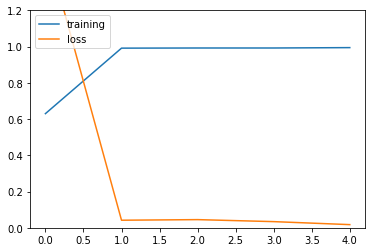

In [21]:
print('Adam')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.ylim(0,1.2)
plt.legend(['training', 'loss'], loc = 'upper left')
plt.show()

In [12]:
def order_points(pts):
  
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]


    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def ret_result(card_num):
        if(card_num != 52):
            mark = card_num // 13
            number = card_num % 13 + 1
        else:
            mark = 4
        
        if(number == 11):
            number = "J"
        elif(number == 12):
            number = "Q"
        elif(number == 13):
            number = "K"
        elif(number == 1):
            number = "A"
        
        if(mark == 0) :
            return("spade {}".format(number))
        elif(mark == 1) :
            return("clover {}".format(number))
        elif(mark == 2) :
            return("diamond {}".format(number))
        elif(mark == 3) : 
            return("heart {}".format(number))
        else:
            return("unknown")

def predict_img(v):
    
    v = v[tf.newaxis,...]
    pred = model.predict(v)
    card_num = pred.argmax()

    return ret_result(card_num)

In [ ]:
def auto_scan_image_via_webcam():
    
    try: 
        cap = cv2.VideoCapture(0)
    except:
        print ('cannot load camera!')
        return
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print ('cannot load camera!')
            break
            
        k = cv2.waitKey(10)
        if k == 27:
            cap.release()
            cv2.destroyAllWindows()
            cv2.waitKey(1)
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        edged = cv2.Canny(gray, 75, 200)

        print ("STEP 1: Edge Detection")
        
        (cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:6]
        
    
        warpeds = []
        screenCnts = []
       
        for c in cnts:
            
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            screenCnt = []
            
           
            if len(approx) == 4:
                contourSize = cv2.contourArea(approx)
                camSize = frame.shape[0] * frame.shape[1]
                ratio = contourSize / camSize
                print (contourSize)
                print (camSize)
                print (ratio)
                
                if ratio > 0.06:
                    screenCnt = approx
                    screenCnts.append(screenCnt)
                    
        
        if len(screenCnt) == 0:
            cv2.imshow("WebCam", frame)
            continue
            
        else:
           
            for v in screenCnts:
                rect = order_points(v.reshape(4, 2))
                (topLeft, topRight, bottomRight, bottomLeft) = rect

                w1 = abs(bottomRight[0] - bottomLeft[0])
                w2 = abs(topRight[0] - topLeft[0])
                h1 = abs(topRight[1] - bottomRight[1])
                h2 = abs(topLeft[1] - bottomLeft[1])
                maxWidth = max([w1, w2])
                maxHeight = max([h1, h2])

                dst = np.float32([[0,0], [maxWidth-1,0], [maxWidth-1,maxHeight-1], [0,maxHeight-1]])

                M = cv2.getPerspectiveTransform(rect, dst)
                warped = cv2.warpPerspective(frame, M, (maxWidth, maxHeight))
                
                
                w = cv2.resize(warped, dsize = (100, 150) , interpolation=cv2.INTER_AREA)

                w=tf.convert_to_tensor(w)
                
                cv2.drawContours(frame, [v] , -1, (0, 255, 0), 2)
                cv2.putText(frame, str(predict_img(w)), (int((topLeft[0]+topRight[0])/2), int(topRight[1])), cv2.FONT_HERSHEY_PLAIN, 2 ,(0,255,255), 2)
                
                
            cv2.imshow("WebCam", frame)
            
            

                
           
            #break
            


    #cap.release()
    #cv2.destroyAllWindows()
    #cv2.waitKey(1)
    
    '''
    for w in warpeds:
        cv2.imshow("Scanned", w)
        w = cv2.resize(w, dsize = (50, 75) , interpolation=cv2.INTER_AREA)

        w=tf.convert_to_tensor(w)
        tf_warpeds.append(w)
        cv2.waitKey(0)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    '''
    
        

if __name__ == '__main__':
   auto_scan_image_via_webcam()